In [8]:
import random
random.seed(0)  
from collections import Counter
import matplotlib.pyplot as plt
import re
from re import RegexFlag
from wordcloud import WordCloud 

In [9]:
import numpy as np
np.random.seed(400)
import pandas as pd
%matplotlib inline  

In [10]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

### LDA 

In [11]:
class LDA(object):
    def __init__(self, K, max_iteration):
        self.K = K
        self.max_iteration = max_iteration

    def sample_from_weights(self, weights):
        total = sum(weights)
        rnd = total * random.random()
        for i, w in enumerate(weights):
            rnd -= w
            if rnd <= 0: return i

    def p_topic_given_document(self, topic, d, alpha=0.1):
        return ((self.document_topic_counts[d][topic] + alpha) /
                (self.document_lengths[d] + self.K * alpha))

    def p_word_given_topic(self, word, topic, beta=0.1):
        return ((self.topic_word_counts[topic][word] + beta) /
                (self.topic_counts[topic] + self.W * beta))

    def topic_weight(self, d, word, topic):
        return self.p_word_given_topic(word, topic) * self.p_topic_given_document(topic, d)

    def choose_new_topic(self, d, word):
        return self.sample_from_weights([self.topic_weight(d, word, k)
                            for k in range(self.K)])

    def gibbs_sample(self, document_topics):
        for _ in range(self.max_iteration):
            for d in range(self.D):
                for i, (word, topic) in enumerate(zip(documents[d], document_topics[d])):
                    self.document_topic_counts[d][topic] -= 1
                    self.topic_word_counts[topic][word] -= 1
                    self.topic_counts[topic] -= 1
                    self.document_lengths[d] -= 1

                    new_topic = self.choose_new_topic(d, word)
                    document_topics[d][i] = new_topic

                    self.document_topic_counts[d][new_topic] += 1
                    self.topic_word_counts[new_topic][word] += 1
                    self.topic_counts[new_topic] += 1
                    self.document_lengths[d] += 1

    def run(self, documents):
        self.document_topic_counts = [Counter() for _ in documents]
        self.topic_word_counts = [Counter() for _ in range(self.K)]
        self.topic_counts = [0 for _ in range(self.K)]
        self.document_lengths = [len(d) for d in documents]
        self.distinct_words = set(word for document in documents for word in document)
        self.W = len(self.distinct_words)
        self.D = len(documents)
        document_topics = [[random.randrange(self.K) for word in document]
                           for document in documents]

        for d in range(self.D):
            for word, topic in zip(documents[d], document_topics[d]):
                self.document_topic_counts[d][topic] += 1
                self.topic_word_counts[topic][word] += 1
                self.topic_counts[topic] += 1

        self.gibbs_sample(document_topics)
        return self.topic_word_counts, self.document_topic_counts

    def plot_words_clouds_topic(self, plt):
        for topic in range(self.K):
            data = []
            text = ""
            for word, count in self.topic_word_counts[topic].most_common():
                if count > 1:
                    data.append(word)
            text = ' '.join(data)
            wordcloud = WordCloud().generate(text)
            plt.figure()
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Topic {topic}")
            plt.show()

### PREPROCESSING

In [12]:
documents=pd.read_csv('abcnews-date-text.csv')
documents.drop(['publish_date'],axis=1,inplace=True)
documents.head()

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers


In [13]:
stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [14]:
reduced_documents = documents['headline_text'].sample(40000)
headline_cleaned_text = reduced_documents.apply(preprocess)

In [15]:
print(headline_cleaned_text)

992410       [socceroo, secur, vital, world, qualifi, kyrgi]
1063800    [south, korean, investig, summon, park, jail, ...
681593                                             [weather]
995445     [bendigo, councillor, plan, soldier, memori, h...
1060670           [govt, backped, law, forc, cyclist, carri]
                                 ...                        
823811            [driver, court, accus, road, rage, attack]
484249                 [irrig, water, flow, select, channel]
1233896                [children, woman, charg, steal, food]
392804                       [burn, bitumen, machin, explos]
1021652                  [monday, market, michael, mccarthi]
Name: headline_text, Length: 40000, dtype: object


In [20]:
documents = headline_cleaned_text.tolist()
# documents = documents[:30000]


### RUNNING THE MODEL AND VISUALISATION

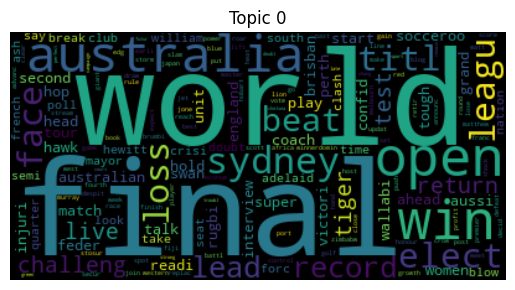

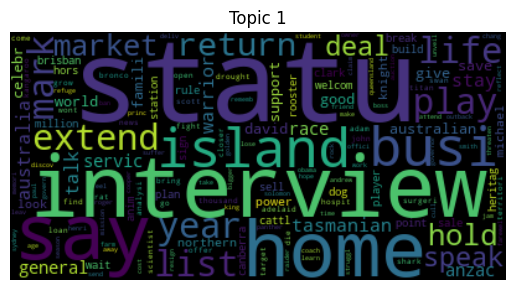

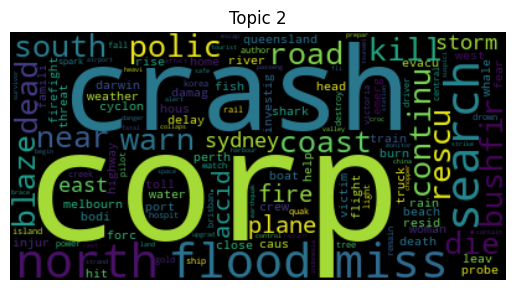

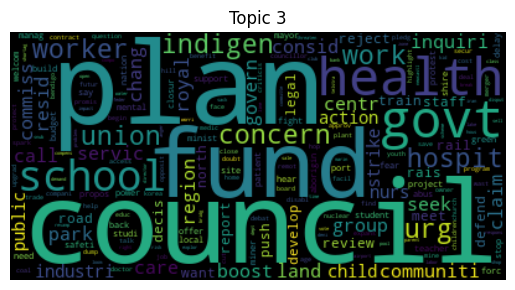

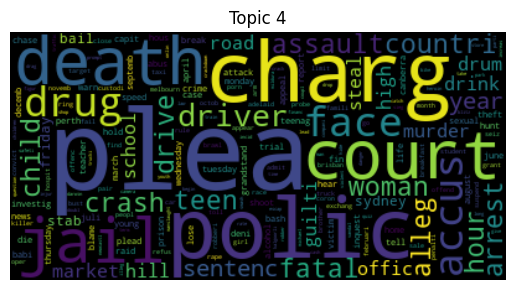

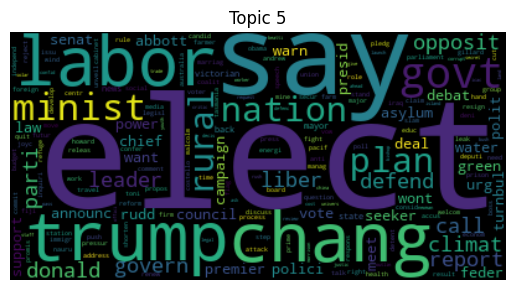

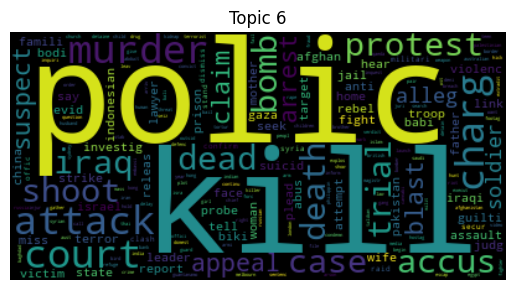

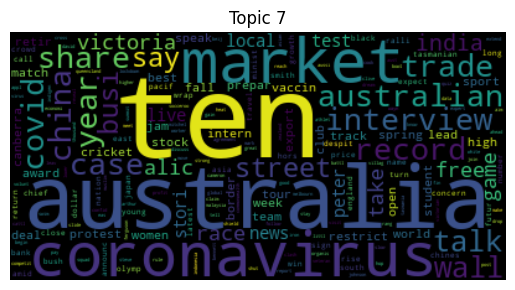

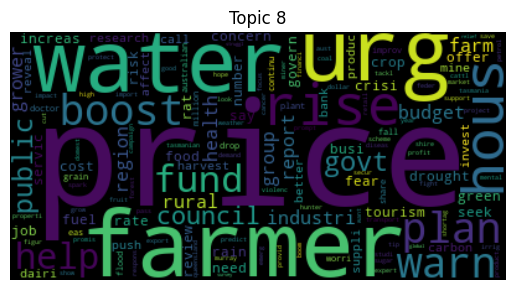

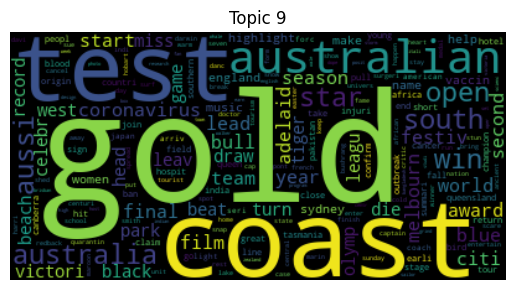

In [17]:
K = 10
max_iteration = 50

lda = LDA(K, max_iteration)
topic_word_counts, document_topic_counts = lda.run(documents)

lda.plot_words_clouds_topic(plt)  

In [26]:
print("Top words for each topic:")
# Print the top words for each topic
for topic_idx, word_counts in enumerate(topic_word_counts):
    top_words = [word for word, count in word_counts.most_common(5)]
    print(f"Topic {topic_idx}: {top_words}")


Top words for each topic:
Topic 0: ['final', 'world', 'open', 'win', 'australia']
Topic 1: ['interview', 'home', 'say', 'island', 'busi']
Topic 2: ['crash', 'flood', 'miss', 'north', 'search']
Topic 3: ['council', 'plan', 'fund', 'health', 'govt']
Topic 4: ['polic', 'charg', 'court', 'death', 'jail']
Topic 5: ['elect', 'say', 'chang', 'trump', 'labor']
Topic 6: ['polic', 'kill', 'murder', 'attack', 'charg']
Topic 7: ['australia', 'coronavirus', 'market', 'australian', 'covid']
Topic 8: ['price', 'farmer', 'water', 'urg', 'rise']
Topic 9: ['gold', 'coast', 'test', 'australian', 'australia']


In [24]:
# Print the topic distribution for the first 5 documents and match with the most suitable topic
for doc_idx, topic_counts in enumerate(document_topic_counts[:5]):
    topic_distribution = np.zeros(K)
    for topic, count in topic_counts.items():
        topic_distribution[topic] = count
    most_suitable_topic = np.argmax(topic_distribution)
    print(f"Document {doc_idx}: {documents[doc_idx]}")
    print(f"  Topic Distribution: {topic_distribution}")
    print(f"  Most Suitable Topic: {most_suitable_topic}")

Document 0: ['socceroo', 'secur', 'vital', 'world', 'qualifi', 'kyrgi']
  Topic Distribution: [4. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
  Most Suitable Topic: 0
Document 1: ['south', 'korean', 'investig', 'summon', 'park', 'jail', 'friend']
  Topic Distribution: [0. 0. 1. 0. 5. 0. 0. 0. 0. 1.]
  Most Suitable Topic: 4
Document 2: ['weather']
  Topic Distribution: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  Most Suitable Topic: 9
Document 3: ['bendigo', 'councillor', 'plan', 'soldier', 'memori', 'hall', 'revamp']
  Topic Distribution: [0. 0. 0. 5. 0. 0. 1. 0. 0. 1.]
  Most Suitable Topic: 3
Document 4: ['govt', 'backped', 'law', 'forc', 'cyclist', 'carri']
  Topic Distribution: [0. 0. 1. 4. 1. 0. 0. 0. 0. 0.]
  Most Suitable Topic: 3
